In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Layout
import numpy as np
import starry

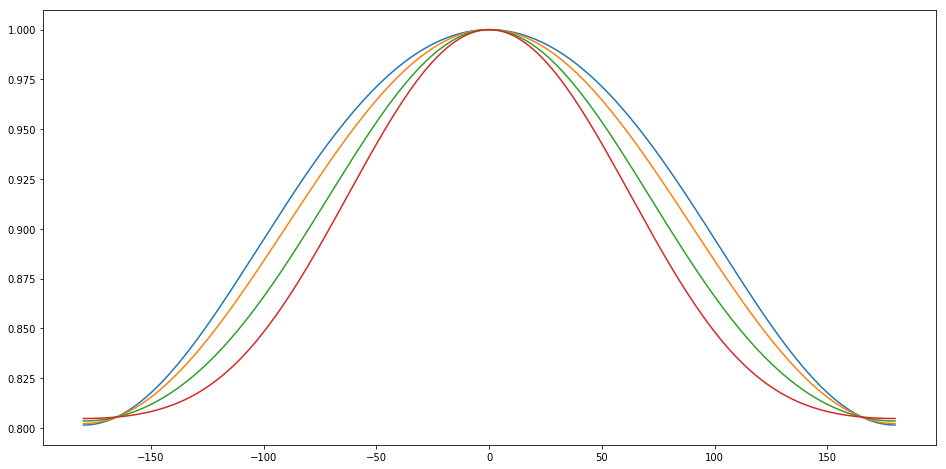

In [14]:
def starry_physical_map(longitude, a=0.3, b=0.0, latitude_model = None, lmax = 3, planet_map = None):
    
    if planet_map is None: planet_map = starry.Map(lmax)
    
    # Check if physical
    if b > np.sqrt(3) / a - 3: warning_message('Negative night flux encountered')
        
    """Interactive visualization."""
    # Set the coeffs
    planet_map[1, 0] = a
    planet_map[2, 0] = -a * b / np.sqrt(15)
    
    if latitude_model is None:
        latitude = np.linspace(-90, 90, len(longitude))
        y = np.sin(latitude * np.pi / 180.)
    else:
        y = latitude_model
    
    # Compute the intensity profile
    intensity = np.zeros((len(y), len(longitude)))
    for i in range(len(longitude)): intensity[:,i] = planet_map(theta=longitude[i], x=0, y=y)
    
    return intensity

def compute_equatorial_flux(longitude, a=0.3, b=0.0, latitude_model = None, lmax = 3, planet_map = None):
    
    if planet_map is None: planet_map = starry.Map(lmax)
    
    intensity = starry_physical_map(longitude, a=a, b=b, latitude_model = latitude_model, lmax = lmax, planet_map = planet_map)
    
    Ieq = np.array(intensity[len(y) // 2])
    Ieq /= np.max(Ieq)
    
    return Ieq

def compute_phase_curve(a, b, longitude, latitude_model = None, lmax = 3, planet_map = None):
    if planet_map is None: planet_map = starry.Map(lmax)
    
    intensity = starry_physical_map(longitude, a=a, b=b, latitude_model = latitude_model, lmax = lmax, planet_map = planet_map)
    
    Ilon = np.sum(intensity, axis=0)
    Ilon /= np.max(Ilon)
    
    return Ilon

a = 0.1
b = 0
longitude = np.linspace(-180,180,200)

fig = plt.figure(figsize=(16,8))
plt.plot(longitude, compute_phase_curve(a, 0.3, longitude, latitude_model = None, lmax = 3, planet_map = None))
plt.plot(longitude, compute_phase_curve(a, 0, longitude, latitude_model = None, lmax = 3, planet_map = None))
plt.plot(longitude, compute_phase_curve(a, -0.5, longitude, latitude_model = None, lmax = 3, planet_map = None))
plt.plot(longitude, compute_phase_curve(a, -1, longitude, latitude_model = None, lmax = 3, planet_map = None))

In [ ]:
longitude = np.linspace(-180, 180, 200)
latitude = np.linspace(-90, 90, 100)
latitude_model = np.sin(latitude * np.pi / 180.)
lmax = 3
map = starry.Map(lmax)
map[0, 0] = 1.0

ls

<img src="integrated_double_digmoid_3param.png">

In [137]:
def int_double_sigmoid(alpha=1., beta=0.01, gamma=50, longitude=None, base=0):
    if longitude is None: np.linspace(-180,180,200)
    # longitude = longitude*np.pi/180
    ratio = alpha / beta
    posterm = np.log(np.exp(-beta*(longitude-gamma))+1)
    negterm = np.log(np.exp(-beta*(longitude+gamma))+1)
    return ratio*(posterm + negterm) + base

In [18]:
import numpy as np

In [36]:
def simple_double_sigmoid(params, longitude): 
    amplitude, scale, shift = params
    
    sigmoid_one = 1/(1+np.exp(-scale*(longitude+shift)))
    sigmoid_two = 1/(1+np.exp(-scale*(longitude-shift)))
    
    return amplitude*(sigmoid_one - sigmoid_two)

def double_sigmoid(params, longitude):
    amplitude, scale1, scale2, shift1, shift2 = params

    sigmoid_one = 1/(1+np.exp(-scale1*(longitude+shift1)))
    sigmoid_two = 1/(1+np.exp(-scale2*(longitude-shift2)))
    
    return amplitude*(sigmoid_one - sigmoid_two)

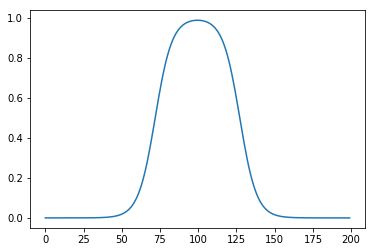

In [40]:
plt.plot(simple_double_sigmoid([1.0, 0.1, 50], longitude))

In [149]:
def int_double_sigmoid(alpha=1., beta=0.01, gamma=50, longitude=None, base=0):
    if longitude is None: longitude = np.linspace(-180,180,200)
    # longitude = longitude*np.pi/180
    ratio = alpha / beta
    posterm = np.log(np.exp(-beta*(longitude-gamma))+1)
    negterm = np.log(np.exp(-beta*(longitude+gamma))+1)
    return ratio*(posterm + negterm) + base

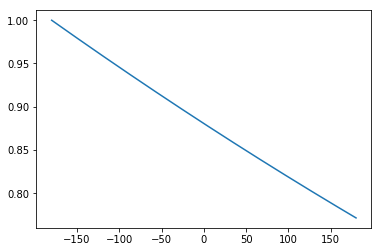

In [157]:
pcurve = int_double_sigmoid(1.0, 0.001, 50)
plt.plot(np.linspace(-180,180,200), pcurve/pcurve.max());

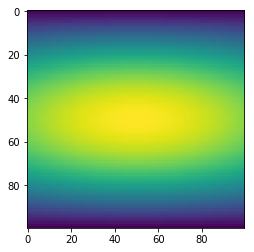

In [117]:
image = np.zeros((100,100))

latitudes, longitudes = np.indices((100,100))
latitudes = (latitudes - latitudes.min()) / (latitudes.max() - latitudes.min())*2-1.0
latitudes = latitudes*90
longitudes = (longitudes - longitudes.min()) / (longitudes.max() - longitudes.min())*2-1.0
longitudes = longitudes*180

long_pattern = simple_double_sigmoid([1.0, 0.005, 50], longitudes)
lat_pattern = 1*np.cos(latitudes * np.pi / 180.)+0.0

plt.imshow(lat_pattern*long_pattern);

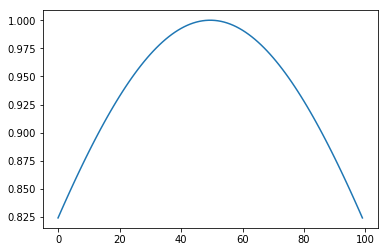

In [118]:
pcurve = np.sum(lat_pattern*long_pattern,axis=0)
plt.plot(pcurve/pcurve.max())